# Data Collection

Please note: this file is consist of 2 main parts, Data Collection & Data Analysis. The collection part was run and the data are saved in the submitted file 'post_detail.csv' (collected at 23:12 9th Dec 2024). To run the collection code again may affect the result of the csv file. If the file is accidentally updated, please find the copy from the same folder as 'post_detail_copy.csv'. Use this file as the data file for the following analysis part. 

In [8]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

In [9]:
# Set up Chrome options to disable image loading
chrome_options = Options()
chrome_prefs = {"profile.managed_default_content_settings.images": 2}
chrome_options.add_experimental_option("prefs", chrome_prefs)
chrome_options.add_argument("--start-maximized")
chrome_options.add_argument("--disable-notifications")

In [10]:
# Set up the WebDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

# Set script timeout to handle long-running scripts
driver.set_script_timeout(30)

# Open the URL
url = "https://bsky.app/search?q=%22left+x%22"
driver.get(url)

# Wait for the page to load
time.sleep(5)

In [11]:
# Wait for the user to login
input("Please login and press Enter to continue:")

# Track the scroll height
last_height = driver.execute_script("return document.body.scrollHeight")

# ChatGPT:'add something to trace the process'
scroll_attempt = 0  # Count the number of scroll attempts

while True:
    try:
        # Scroll down to the bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        scroll_attempt += 1
        print(f"Scroll attempt {scroll_attempt}...")

        # Wait for new content to load
        time.sleep(5)

        # Calculate new scroll height and compare with the last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            print("Reached the end of the page. No more content to load.")
            break
        last_height = new_height

    except:
        print("An error occurred during scrolling")
        break

print("Scrolling completed.")

Please login and press Enter to continue: 


Scroll attempt 1...
Reached the end of the page. No more content to load.
Scrolling completed.


Up to now, the basic code is borrowed from the github project (https://github.com/fcgouveia/BlueSkyScraper) for the preset of scrapping.

**I did some modification on:**
1. add a printed tracker of the page scrolling
2. manually log in on the browser, that allows it to access to all the posts (otherwise I can only get a limited number)
3. use the 'top' option instead of the 'latest', which always cause timeout error when scrapping and can’t trace back to 28 days (sometimes even 20 days) earlier. In this case, top posts are also more representative for our data collection.

The timestamp and the post text are kept in different tags:

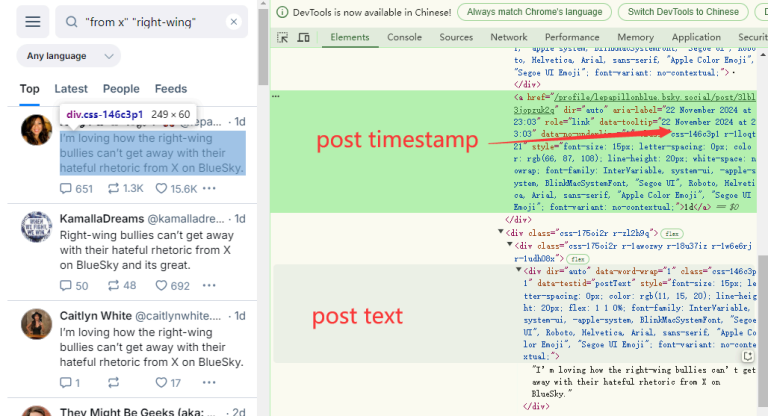

To retrieve data from the HTML file, python collects each timestamp (data-tooltip) first, and then the post text following it.

**The original code is as follows:**

```
links = driver.find_elements(By.TAG_NAME, "a")

link_urls = [link.get_attribute("href") for link in links if link.get_attribute("href") is not None]
```

**I asked ChatGPT to modify it to 'collect the post text using html tag `<div data-testid='postText'>`'**

In [12]:
# ChatGPT: 'modify the code to retrieve both tooltip and posttext'

# Find all tooltip elements first
tooltips = driver.find_elements(By.XPATH, '//a[@data-tooltip]')

# Log the number of tooltips found
print(f"Found {len(tooltips)} tooltips.")

# Prepare a list to store post text and tooltip data
post_details = []

# Loop through tooltips
for index, tooltip in enumerate(tooltips):
    print(f"Processing tooltip {index + 1}/{len(tooltips)}...")

    # Extract tooltip text
    tooltip_data = tooltip.get_attribute("data-tooltip")
    print(f"Tooltip data: {tooltip_data}")

    try:
        # Find the corresponding post text related to the tooltip (in the same parent div)
        post_text_element = tooltip.find_element(By.XPATH, './/following::div[@data-testid="postText"]')
        post_text = post_text_element.text.strip()  # Extract and clean text
    except Exception as e:
        post_text = None  # Handle missing post text gracefully
        print(f"Post text not found for tooltip {index + 1}. Error: {e}")

    # Append post text and tooltip data to the list
    post_details.append({"post_text": post_text, "tooltip": tooltip_data})

# Log completion of the process
print("Processing complete. Details collected:")
print(post_details)


Found 22 tooltips.
Processing tooltip 1/22...
Tooltip data: 2024年12月29日 17:15
Processing tooltip 2/22...
Tooltip data: 2024年12月28日 17:52
Processing tooltip 3/22...
Tooltip data: 2024年12月28日 22:12
Processing tooltip 4/22...
Tooltip data: 2024年12月29日 01:08
Processing tooltip 5/22...
Tooltip data: 2024年12月27日 02:20
Processing tooltip 6/22...
Tooltip data: 2024年12月29日 20:59
Processing tooltip 7/22...
Tooltip data: 2024年12月27日 22:20
Processing tooltip 8/22...
Tooltip data: 2024年12月29日 23:42
Processing tooltip 9/22...
Tooltip data: 2024年12月29日 21:08
Processing tooltip 10/22...
Tooltip data: 2024年12月28日 19:37
Processing tooltip 11/22...
Tooltip data: 2024年12月26日 21:08
Processing tooltip 12/22...
Tooltip data: 2024年12月27日 18:57
Processing tooltip 13/22...
Tooltip data: 2024年12月30日 19:09
Processing tooltip 14/22...
Tooltip data: 2024年12月27日 03:23
Processing tooltip 15/22...
Tooltip data: 2024年12月27日 04:29
Processing tooltip 16/22...
Tooltip data: 2024年12月30日 02:59
Processing tooltip 17/22...
To

In [13]:
# Print out the extracted data
# ChatGPT: 'modify this to save the posttext and time to a df and then a csv file with columns: number, time, posttext'

# Prepare the data for the DataFrame
data = []
for i, detail in enumerate(post_details, start=1):
    data.append({
        "number": i,
        "time": detail["tooltip"],
        "posttext": detail["post_text"]
    })

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_filename = "post_details.csv"
df.to_csv(csv_filename, index=False)

# Confirm success
print(f"Data saved to {csv_filename}")

Data saved to post_details.csv


# Data Analysis
Since the data is not easy to collect, it was saved in a file to be analysed any time instead of running the whole code again.

The data I analyse below is collected at 23:12 9th Dec 2024.

## Posts Throughout Time
The following part is to examine how many posts are made over time. 

In [1]:
# reload the df from saved csv file
import pandas as pd
df =  pd.read_csv('post_details.csv')
print(df)

      number                      time  \
0          1  8 December 2024 at 23:11   
1          2  7 December 2024 at 19:33   
2          3  8 December 2024 at 22:02   
3          4  7 December 2024 at 03:58   
4          5  7 December 2024 at 02:03   
...      ...                       ...   
8260    8261  5 December 2024 at 00:03   
8261    8262  5 December 2024 at 16:08   
8262    8263  5 December 2024 at 11:46   
8263    8264  5 December 2024 at 12:32   
8264    8265  5 December 2024 at 15:21   

                                               posttext  
0     Jess Piper, now a top 500 Bluesky account left...  
1       Left X on November 13th. Not one single regret.  
2     I know you left X because of the terrible cont...  
3                                     is left x-wing ok  
4                               Left X-Wing (Star Wars)  
...                                                 ...  
8260  You’re in the wrong platform. We left X all fo...  
8261  WHY??? Why is X here? We 

In [2]:
# ChatGPT: 'convert the time from df into unix timestamp, but only keep the date information'

import pandas as pd
from datetime import datetime

# Function to convert timestamp to Unix time but to drop the specific time 
def to_unix_time(time_str):
    clean_timestamp = time_str.replace(" at ", " ")
    # Parse the date and time
    date_time = datetime.strptime(clean_timestamp, "%d %B %Y %H:%M")
    # Create a new datetime object with time set to 00:00:00 (midnight)
    date_only_unix = date_time.replace(hour=0, minute=0, second=0, microsecond=0)
    return int(date_only_unix.timestamp())
df['unixdate'] = df.time.apply(to_unix_time)

# Display the updated DataFrame
print(df)

      number                      time  \
0          1  8 December 2024 at 23:11   
1          2  7 December 2024 at 19:33   
2          3  8 December 2024 at 22:02   
3          4  7 December 2024 at 03:58   
4          5  7 December 2024 at 02:03   
...      ...                       ...   
8260    8261  5 December 2024 at 00:03   
8261    8262  5 December 2024 at 16:08   
8262    8263  5 December 2024 at 11:46   
8263    8264  5 December 2024 at 12:32   
8264    8265  5 December 2024 at 15:21   

                                               posttext    unixdate  
0     Jess Piper, now a top 500 Bluesky account left...  1733616000  
1       Left X on November 13th. Not one single regret.  1733529600  
2     I know you left X because of the terrible cont...  1733616000  
3                                     is left x-wing ok  1733529600  
4                               Left X-Wing (Star Wars)  1733529600  
...                                                 ...         ...  
8260 

                     post_daily
unixdate                       
2023-07-26 23:00:00           1
2023-07-30 23:00:00           1
2023-08-01 23:00:00           1
2023-08-02 23:00:00           1
2023-08-05 23:00:00           3
...                         ...
2024-12-05 00:00:00          77
2024-12-06 00:00:00          79
2024-12-07 00:00:00          65
2024-12-08 00:00:00          79
2024-12-09 00:00:00          57

[381 rows x 1 columns]


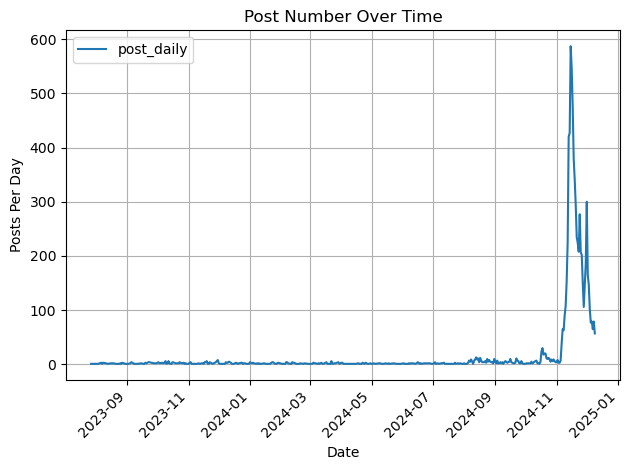

In [3]:
import matplotlib.pyplot as plt

s = df.groupby('unixdate')['number'].count()

# Convert the 'unixdate' index to readable dates (ChatGPT)
s.index = pd.to_datetime(s.index, unit='s')

timedf = pd.DataFrame({'post_daily':s})
print(timedf)

timedf.plot.line()
# Customize the plot (ChatGPT)
plt.title('Post Number Over Time')
plt.xlabel('Date')
plt.ylabel('Posts Per Day')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

                     post_daily
unixdate                       
2024-08-01 23:00:00           1
2024-08-03 23:00:00           1
2024-08-04 23:00:00           3
2024-08-05 23:00:00           7
2024-08-06 23:00:00           5
...                         ...
2024-12-05 00:00:00          77
2024-12-06 00:00:00          79
2024-12-07 00:00:00          65
2024-12-08 00:00:00          79
2024-12-09 00:00:00          57

[125 rows x 1 columns]


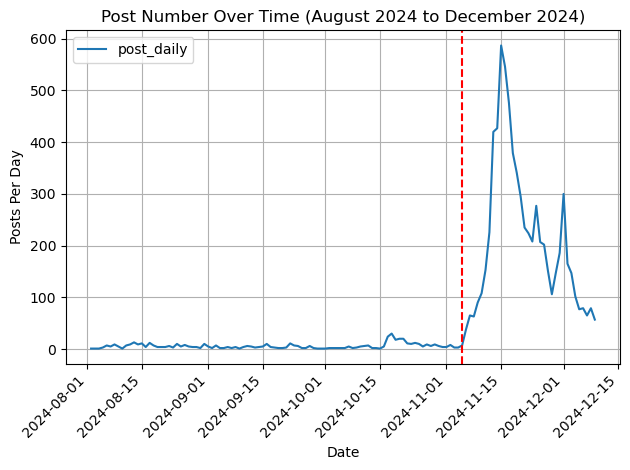

In [4]:
# ChatGPT: 'Zoom into the date range August 2024 to December 2024'

start_date = '2024-08-01'
end_date = '2024-12-10'
timedf = pd.DataFrame({'post_daily': s[(s.index >= start_date) & (s.index <= end_date)]})
print(timedf)

# Plotting the line graph for daily post counts within the date range
timedf.plot.line()
plt.title('Post Number Over Time (August 2024 to December 2024)')
plt.xlabel('Date')
plt.ylabel('Posts Per Day')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)

# Add a vertical line indicating the election day 5th November 2024 (ChatGPT)
election_day = '2024-11-05'
plt.axvline(pd.to_datetime(election_day), color='red', linestyle='--', label='Election Day')

# Show the plot
plt.tight_layout()
plt.show()

## Text Analysis
In this part, SpaCy is used to tag the words, specifically adjectives and entities in this case.

Before **adjectives** are used to reflect users opinions on the event while **entities** show how related it is to these people or matters.

In [5]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

text = ' '.join(df['posttext'].dropna())
text = text.lower()
words = re.findall(r'\w+', text)

# Remove stop words (ChatGPT)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

word_frequencies = Counter(filtered_words)
common_words = word_frequencies.most_common()
freq_df = pd.DataFrame(common_words, columns=["Word", "Frequency"])
filtered_df = freq_df[(freq_df["Frequency"] > 50) & (freq_df["Frequency"] < 1240)] # To exclude the long tail and 3 topic words, 'X', 'left' and 'bluesky'.
print(filtered_df)

        Word  Frequency
3     people       1208
4       like        972
5    twitter        812
6        see        733
7        ago        699
..       ...        ...
313     guys         51
314     mind         51
315      ads         51
316    tried         51
317  decided         51

[315 rows x 2 columns]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jiaxin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import spacy

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize empty lists for tags
pos_tags = []

# Process each word in the DataFrame
for word in filtered_df["Word"]:
    doc = nlp(word)
    token = doc[0]  # Process single-token words
    pos_tags.append(token.pos_)  # Get POS tag

# Add tags to DataFrame
filtered_df["POS"] = pos_tags

print(filtered_df)

        Word  Frequency   POS
3     people       1208  NOUN
4       like        972  INTJ
5    twitter        812  NOUN
6        see        733  VERB
7        ago        699   ADV
..       ...        ...   ...
313     guys         51  NOUN
314     mind         51  NOUN
315      ads         51  NOUN
316    tried         51  VERB
317  decided         51  VERB

[315 rows x 3 columns]


C:\Users\Jiaxin\AppData\Local\Temp\ipykernel_4820\2175536461.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["POS"] = pos_tags


         Word  Frequency   POS
3      people       1208  NOUN
5     twitter        812  NOUN
8        good        662   ADJ
9      social        574   ADJ
10       glad        573   ADJ
..        ...        ...   ...
309     funny         52   ADJ
312  guardian         52  NOUN
313      guys         51  NOUN
314      mind         51  NOUN
315       ads         51  NOUN

[118 rows x 3 columns]


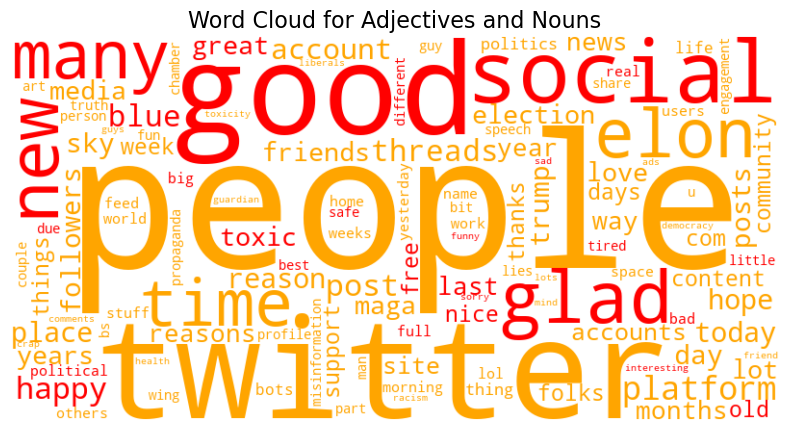

In [7]:
# ChatGPT: use spaCy to parse the words from freq_df and generate word cloud for adjectives and nouns, make them red and orange respectively.

words = filtered_df[(filtered_df["POS"] == "ADJ") | (filtered_df["POS"] == "NOUN")]
print(words)
type(words)

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.colors import to_rgba

# Convert filtered DataFrame to a dictionary
word_freq = dict(zip(words["Word"], words["Frequency"]))
pos_dict = dict(zip(words["Word"], words["POS"]))

# Generate the word cloud with the custom color function
def custom_color_func(word, **kwargs):
    if pos_dict.get(word) == "ADJ":
        return "red"
    elif pos_dict.get(word) == "NOUN":
        return "orange"
    return "black"  # Default color for other words
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
wordcloud.recolor(color_func=custom_color_func)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Adjectives and Nouns", fontsize=16)
plt.show()

## Reflection And Further Analysis
As the result shows, an interesting finding is that 'Elon' is far more frequent than 'Trump' in the word count, which leads to a new question: will the results be the same after the time element (election day) is taken into consideration?

The following code is mainly borrowed from above with some adjustment for the Musk & Trump query with the help of AI assistant.

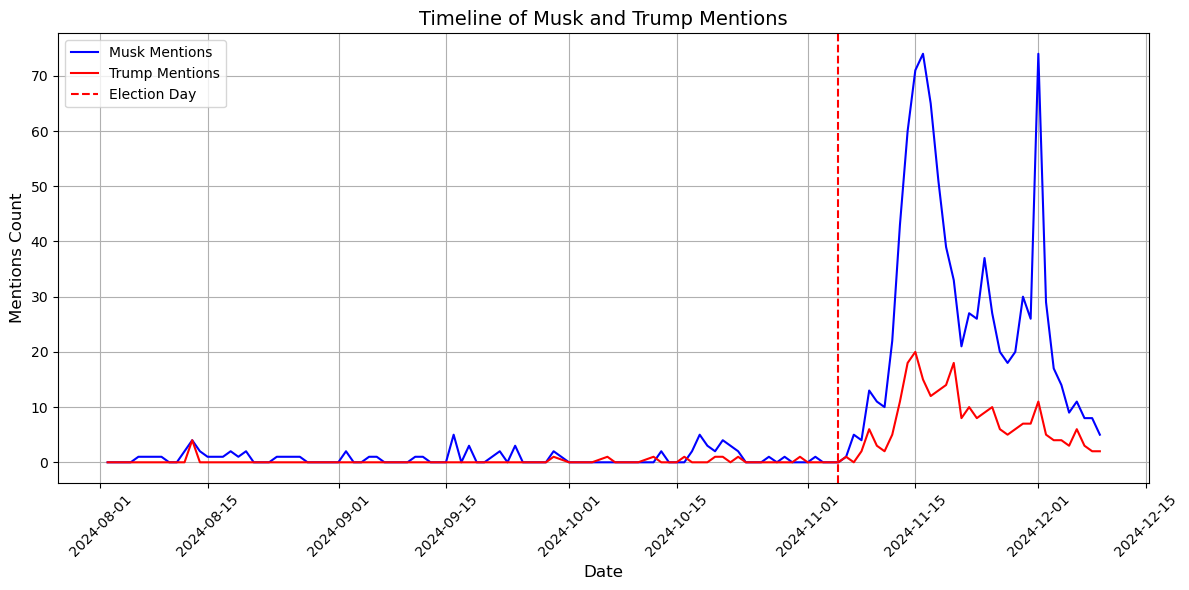

In [8]:
import matplotlib.pyplot as plt

# Ensure 'unixdate' is in datetime format
df['unixdate'] = pd.to_datetime(df['unixdate'], unit='s')

# Count mentions of "Musk" and "Trump" by date (ChatGPT)
df['Musk_Mentions'] = df['posttext'].str.findall(r"\b(Elon|Musk)\b", flags=re.IGNORECASE).str.len()
df['Trump_Mentions'] = df['posttext'].str.findall(r"\b(Donald|Trump)\b", flags=re.IGNORECASE).str.len()

s1 = df.groupby('unixdate')['Musk_Mentions'].sum()
s2 = df.groupby('unixdate')['Trump_Mentions'].sum()

# Filter data to show only from August 2024 to December 2024
start_date = '2024-08-01'
end_date = '2024-12-10'
s1 = s1[(s1.index >= start_date) & (s1.index <= end_date)]
s2 = s2[(s2.index >= start_date) & (s2.index <= end_date)]

# Plotting the timeline
plt.figure(figsize=(12, 6))
plt.plot(s1.index, s1, label="Musk Mentions", color='blue', linestyle='-')
plt.plot(s2.index, s2, label="Trump Mentions", color='red', linestyle='-')
election_day = '2024-11-05'
plt.axvline(pd.to_datetime(election_day), color='red', linestyle='--', label='Election Day')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Mentions Count", fontsize=12)
plt.title("Timeline of Musk and Trump Mentions", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()